Names and PRN for all group members:
- Name: Rajesh Singh
- PRN:  240840128028
- Date: 30/11/2024

# Deep Neural Networks
## A07: Group Assignment


##  Convolutional Neural Network (CNN)

- Flowers Dataset


In [1]:
###-----------------
### Import Libraries
###-----------------
import sys


sys.path.append('../')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import tensorflow as tf


from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix


In [2]:
###----------------
# Global Variables
###----------------


RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)



TEST_SIZE =  0.2
ALPHA = 0.001
EPOCHS = 35
BATCH_SIZE = 32
PATIENCE = 6
LR_FACTOR = 0.1
LR_PATIENCE = 20
IMG_HEIGHT= 188
IMG_WIDTH= 188

# set location of input files and output files
inpDir = '../input'
outDir = '../output'
modelDir = '../models' 
subDir = 'flower_photos'
altName = 'baes_model'

###----------------------
### Some basic parameters
###----------------------

# Set plotting parameters
params = {
    'figure.figsize': (15,4),
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
}
plt.rcParams.update(params)


CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')


## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [3]:
'''
    For reading from web link
'''
#import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                   fname='flower_photos',
#                                   untar=True)
#data_dir = pathlib.Path(data_dir)
'''
    For reading from local directory
'''
data_dir = os.path.join(inpDir, subDir)

In [4]:
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    subset="training",
    seed=RANDOM_STATE,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=TEST_SIZE,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    subset="validation",
    seed=RANDOM_STATE,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=TEST_SIZE,
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)

display(class_names, num_classes)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

5

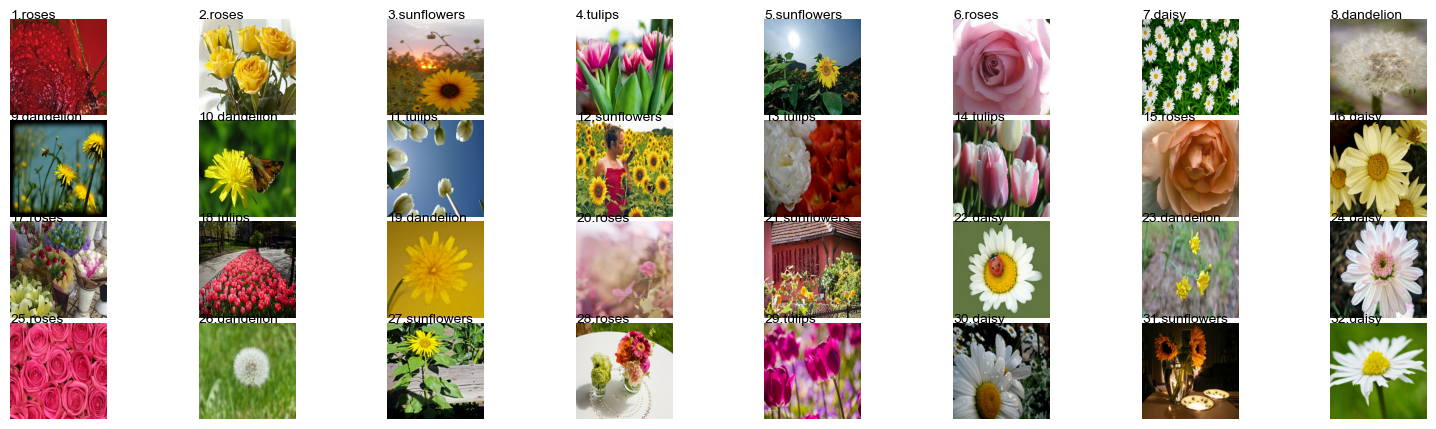

In [7]:
#create a new figure for the grid of images with a specified size
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
i = 0
#  Take 1 Batch
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE//8, 8, i+1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.text(
            x=0,
            y=0,
            s=f'{i+1}.{class_names[labels[i].numpy()]}', 
            color='black', 
            fontsize=10
        )
        plt.axis('off')
        
    plt.show()
    i += 1

plt.show()  


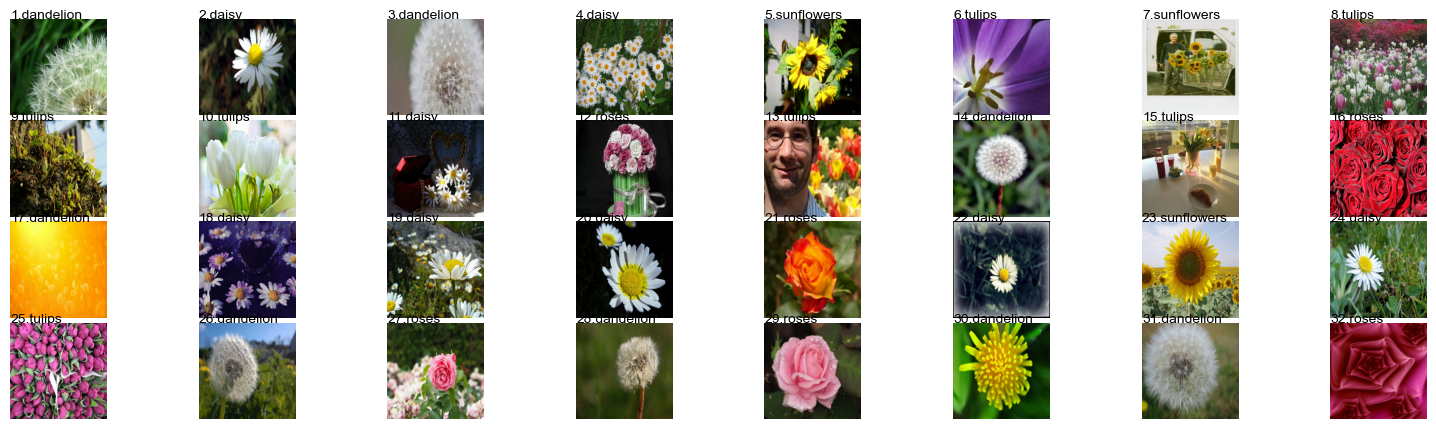

In [8]:
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
i = 0
#  Take 1 Batch
for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE//8, 8, i+1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.text(
            x=0,
            y=0,
            s=f'{i+1}.{class_names[labels[i].numpy()]}', 
            color='black', 
            fontsize=10
        )
        plt.axis('off')
        
    plt.show()
    i += 1

plt.show()  


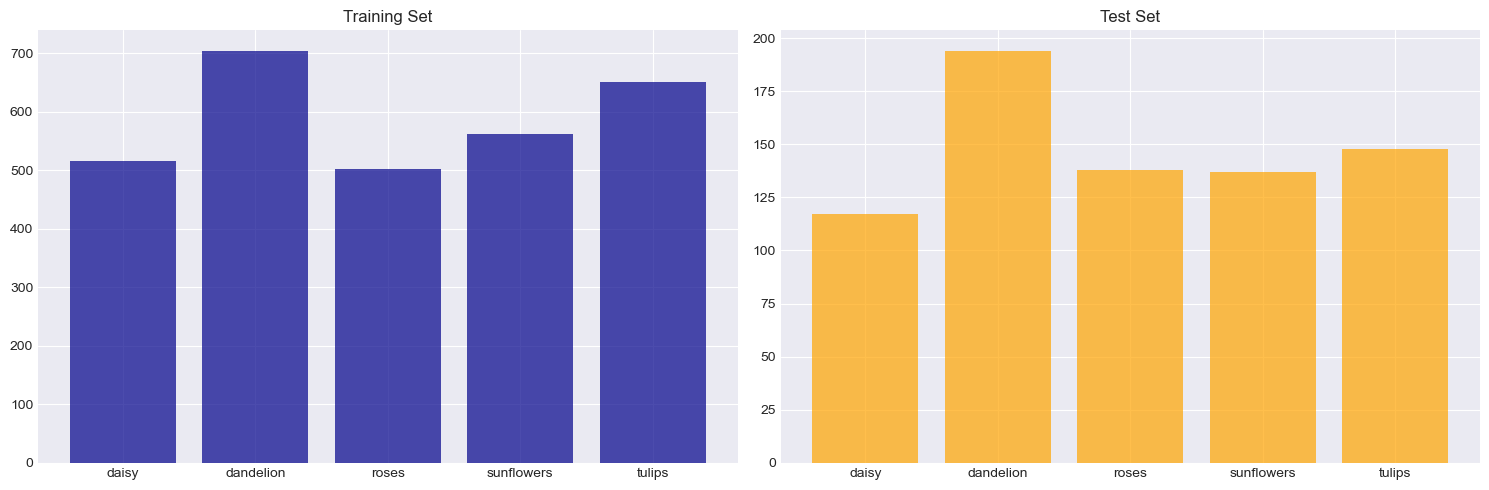

In [9]:
from utils.helper import fn_plot_label
fn_plot_label(train_ds,test_ds) 

In [10]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

### Data Augmentation

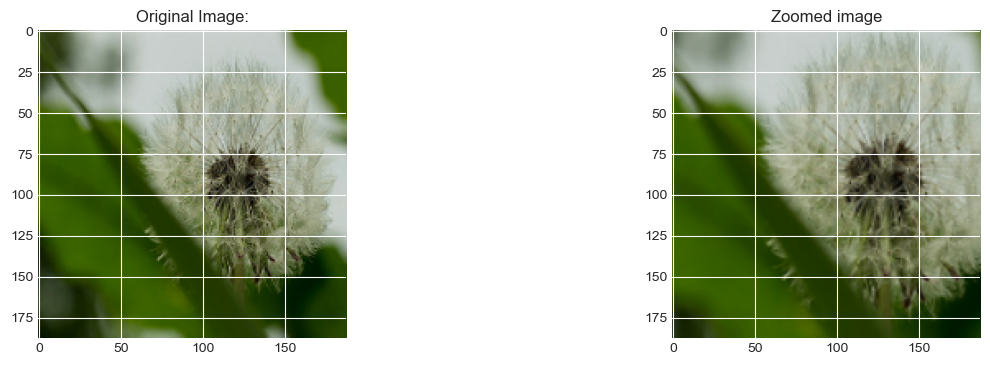

In [11]:
# zoom layer
layer_zoom = tf.keras.layers.RandomZoom(height_factor= (-.2, -.2),
                                   width_factor=(-.2, -.2),
                                   fill_value=0.0,
                                   seed=RANDOM_STATE)

plt.figure()
img_num = 2
for imgs, lbls in train_ds.take(1):
    out_images = layer_zoom(imgs) # applying the layer on the images in the dataset
    plt.subplot(1,2,1)
    plt.title('Original Image:')
    plt.imshow(imgs[img_num].numpy().astype('uint8'))
    # zoomed image
    plt.subplot(1,2,2)
    plt.title('Zoomed image')
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

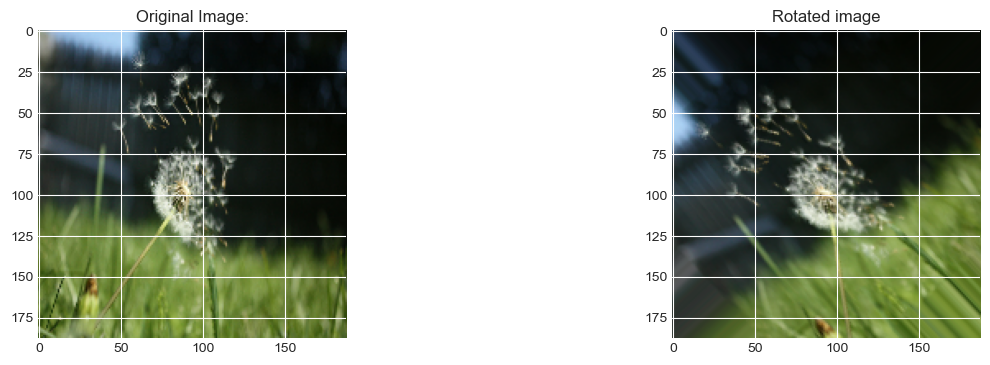

In [12]:
# rotation of the image
layer_rotate = tf.keras.layers.RandomRotation((-0.2, 0.2), fill_mode='nearest', seed=RANDOM_STATE)
plt.figure()
img_num = 2
for imgs, lbls in train_ds.take(1):
    out_images = layer_rotate(imgs) # applying the layer on the images in the dataset
    plt.subplot(1,2,1)
    plt.title('Original Image:')
    plt.imshow(imgs[img_num].numpy().astype('uint8'))
    # zoomed image
    plt.subplot(1,2,2)
    plt.title('Rotated image')
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

In [13]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
# preparing the model
dor1, dor2, dor3, dor4, dor5, dor6 = 0.1, 0.2, 0.2, 0.3, 0.2, 0.2


# Regularizers
krnl_init = tf.keras.initializers.HeNormal(seed=RANDOM_STATE)
krnl_regularizer = None # tf.keras.regularizers.L2(l2=0.01)



# input layer
inputs = tf.keras.Input(shape=input_shape, name='input')
# rescaling layer
x = tf.keras.layers.Rescaling(1./255.)(inputs)




# convolutional layer 1
x = tf.keras.layers.Conv2D(
    64, (3,3), 
    kernel_regularizer=krnl_regularizer, 
    kernel_initializer=krnl_init, 
    padding='same', 
    activation='relu', 
    name='conv_1')(x) # 188x188x64
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
# x = tf.keras.layers.Dropout(dor1)(x)
# max pooling layer 1
x = tf.keras.layers.MaxPool2D(
    pool_size=(2,2), 
    padding='same', 
    name='maxpool_1'
)(x) # 94x94x64 





# convolutional layer 2
x = tf.keras.layers.Conv2D(
    128, (3,3), 
    kernel_regularizer=krnl_regularizer, 
    kernel_initializer=krnl_init, 
    padding='valid', 
    activation='relu', 
    name='conv_2')(x) # 12x12x64
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
# x = tf.keras.layers.Dropout(dor2)(x)
# max pooling layer 2
x = tf.keras.layers.MaxPool2D(
    pool_size=(2,2), 
    padding='valid', 
    name='maxpool_2'
)(x) #  46x46x128




# convolutional layer 3
x = tf.keras.layers.Conv2D(
    256, (3,3), 
    kernel_regularizer=krnl_regularizer, 
    kernel_initializer=krnl_init, 
    padding='valid', 
    activation='relu', 
    name='conv_3')(x) # 44x44x256
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
# x = tf.keras.layers.Dropout(dor2)(x)
# max pooling layer 3
x = tf.keras.layers.MaxPool2D(
    pool_size=(2,2), 
    padding='valid', 
    name='maxpool_3'
)(x) #  20x20x256




# convolutional layer 4
x = tf.keras.layers.Conv2D(
    512, (3,3), 
    kernel_regularizer=krnl_regularizer, 
    kernel_initializer=krnl_init, 
    padding='valid', 
    activation='relu', 
    name='conv_4')(x) # 20x20x512
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
# x = tf.keras.layers.Dropout(dor2)(x)
# max pooling layer 4
x = tf.keras.layers.MaxPool2D(
    pool_size=(2,2), 
    padding='valid', 
    name='maxpool_4'
)(x) #  10x10x512





# convolutional layer 5
x = tf.keras.layers.Conv2D(
    1024, (3,3), 
    kernel_regularizer=krnl_regularizer, 
    kernel_initializer=krnl_init, 
    padding='valid', 
    activation='relu', 
    name='conv_5')(x) # 8x8x1024
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
# x = tf.keras.layers.Dropout(dor2)(x)
# max pooling layer 2
x = tf.keras.layers.MaxPool2D(
    pool_size=(2,2), 
    padding='valid', 
    name='maxpool_5'
)(x) #  4x4x1024





# convolutional layer 6
x = tf.keras.layers.Conv2D(
    2048, (3,3), 
    kernel_regularizer=krnl_regularizer, 
    kernel_initializer=krnl_init, 
    padding='valid', 
    activation='relu', 
    name='conv_6')(x) # 4x4x2048
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
# x = tf.keras.layers.Dropout(dor2)(x)




# flattening layer
x = tf.keras.layers.Flatten()(x)



# dense layers 1
x = tf.keras.layers.Dense(
    1024,
    kernel_regularizer=krnl_regularizer, 
    kernel_initializer=krnl_init, 
    activation='relu', 
    name='dense_1'
)(x)
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
# x = tf.keras.layers.Dropout(dor4)(x)

# dense layers 2
x = tf.keras.layers.Dense(
    128,
    kernel_regularizer=krnl_regularizer, 
    kernel_initializer=krnl_init, 
    activation='relu', 
    name='dense_2'
)(x)
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
# x = tf.keras.layers.Dropout(dor5)(x)

# dense layers 3
outputs = tf.keras.layers.Dense(
    5, 
    kernel_initializer=krnl_init, 
    name='output'
)(x)

In [24]:
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='MNIST_CNN')
model.summary()

Model: "MNIST_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 188, 188, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 188, 188, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 188, 188, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 188, 188, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 94, 94, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 92, 92, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_18 (ReLU)                 │ (None, 92, 92, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 46, 46, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 44, 44, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_19 (ReLU)                 │ (None, 44, 44, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 20, 20, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_20 (ReLU)                 │ (None, 20, 20, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_4 (MaxPooling2D)        │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 8, 8, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_5 (MaxPooling2D)        │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 2, 2, 2048)     │    18,876,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 2, 2, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           64

 Total params: 33,668,485 (128.44 MB)

 Trainable params: 33,668,485 (128.44 MB)

 Non-trainable params: 0 (0.00 B)

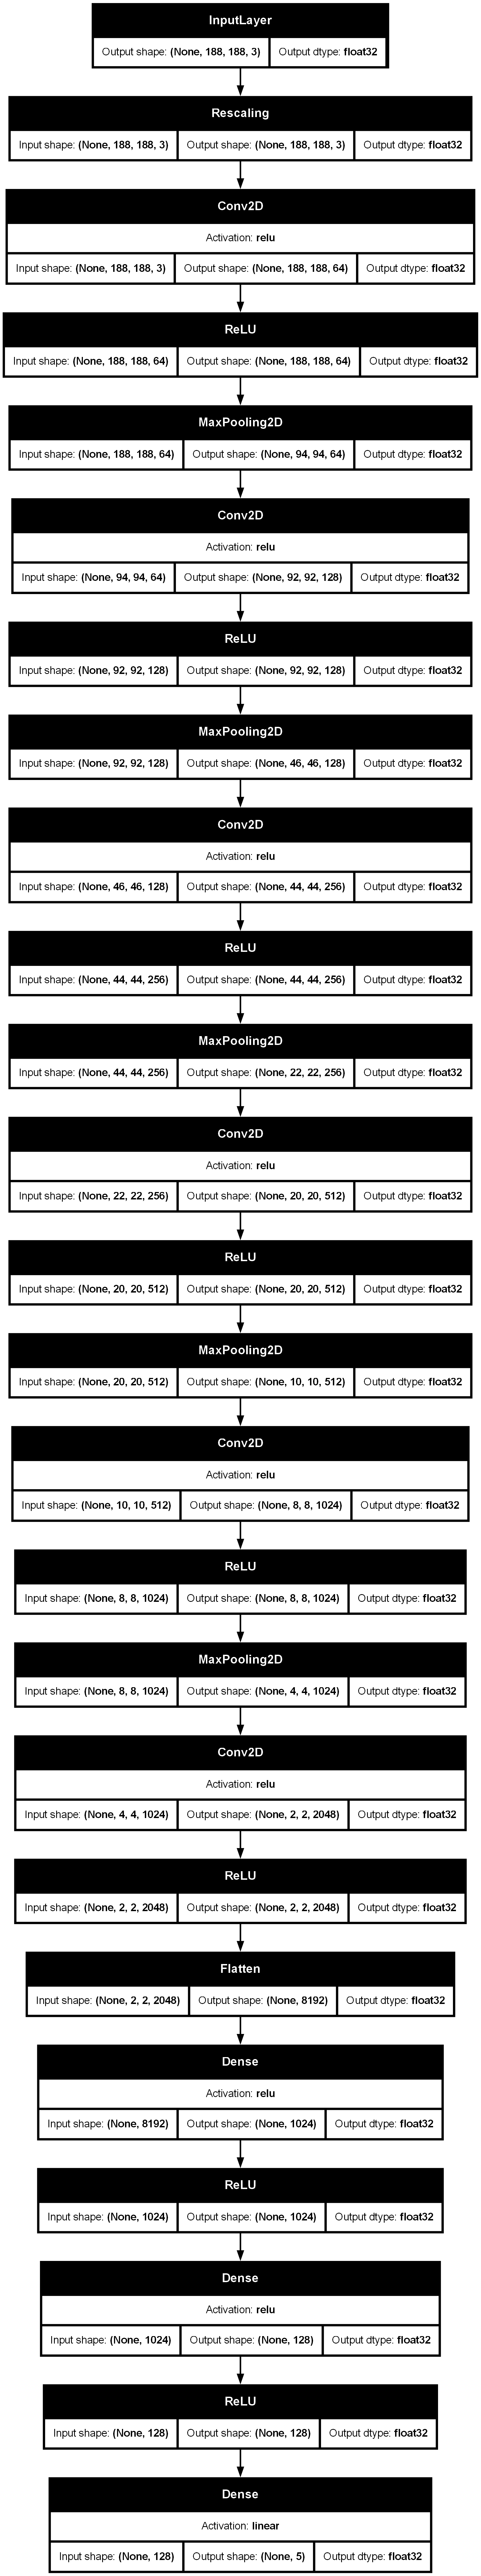

In [25]:
tf.keras.utils.plot_model(
    model, 
    os.path.join(outDir, 'flower_photo.png'),
    show_shapes=True, 
    show_dtype=True, 
    show_layer_activations=True
)

In [26]:
# compling the model after defining the adam and loss functions
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [27]:
check_file_path = os.path.join(modelDir, subDir, 'cnn.weights.h5')

# CHeckpoint 
mbc = tf.keras.callbacks.ModelCheckpoint(
    filepath = check_file_path,
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

# Early Stopping
escb = tf.keras.callbacks.EarlyStopping(
    patience = PATIENCE,
    verbose = 1,
    restore_best_weights = True
)

# Reduce on Plateau
lrcb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = LR_FACTOR,
    patience = LR_PATIENCE,
    verbose = 1
)

In [28]:
history = model.fit(
    train_ds, 
    epochs=EPOCHS, 
    validation_data=test_ds,
    callbacks = [
        mbc,
        escb,
        lrcb
    ],
)


Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2672 - loss: 7.4132
Epoch 1: val_loss improved from inf to 1.32705, saving model to ../models\flower_photos\cnn.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.2676 - loss: 7.3653 - val_accuracy: 0.3896 - val_loss: 1.3271 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4779 - loss: 1.2417
Epoch 2: val_loss improved from 1.32705 to 1.18034, saving model to ../models\flower_photos\cnn.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.4784 - loss: 1.2407 - val_accuracy: 0.5232 - val_loss: 1.1803 - learning_rate: 0.0010
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5789 - loss: 1.0208
Epoch 3: val_loss improved from 1.18034 to 0.91870, saving model to ../models\flower_photos\cnn.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.5792 - loss: 1.0200 - val_accuracy: 0.6158 - val_loss: 0.9187 - learning_rate: 0.0010
Epoch 4/50
92/

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.304837,2.959296,0.389646,1.327050,0.001
1,0.524864,1.145929,0.523161,1.180341,0.001
2,0.603883,0.953079,0.615804,0.918695,0.001


,accuracy,loss,val_accuracy,val_loss,learning_rate
10,0.834809,0.438167,0.698910,1.200076,0.001
11,0.867507,0.370469,0.717984,1.338432,0.001
12,0.890668,0.308683,0.720708,1.480786,0.001


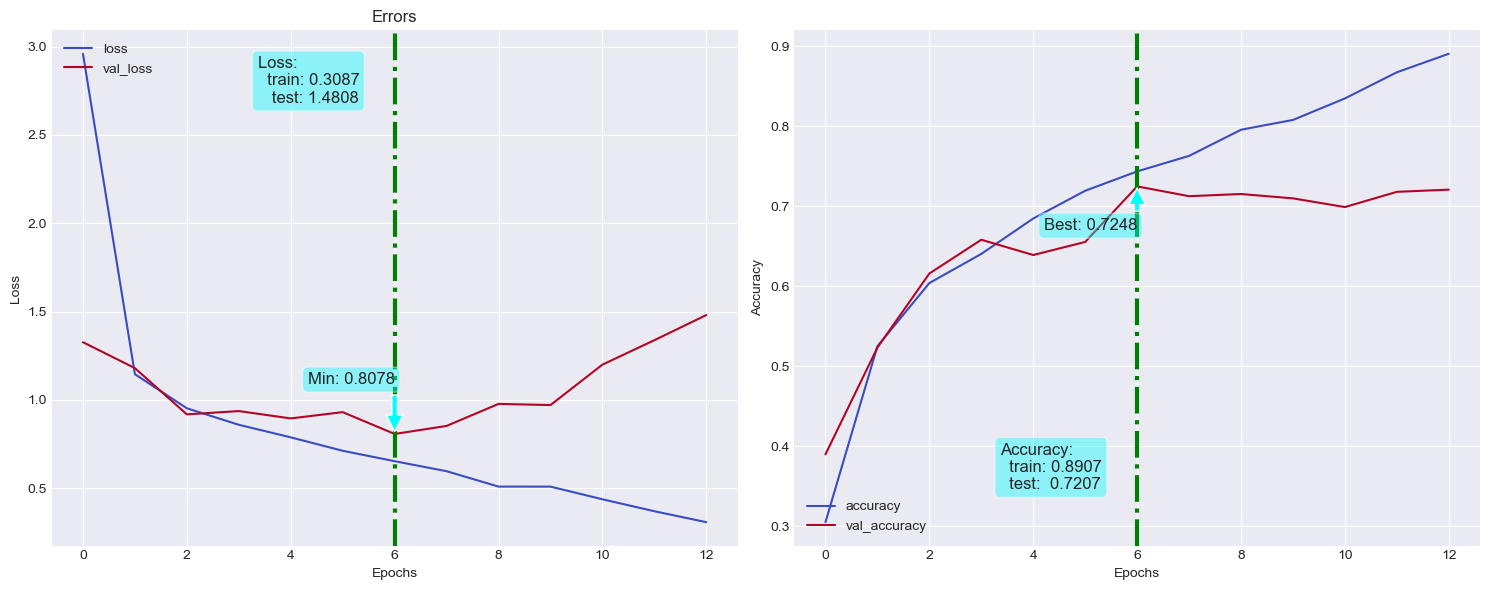

In [29]:
# results and inferences
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fn_plot_tf_hist(hist_df = hist_df)




In [30]:
y_true, y_pred = [], []

for batch_idx, (X, y) in enumerate(test_ds):
    y_true.append(y)
    y_pred.append(model(X))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

y_pred = np.argmax(y_pred, axis=1)


print(f'Accuracy: {accuracy_score(y_true, y_pred):.2f}')

Accuracy: 0.72


### Reload best Weights for evaluation

### Evaluate the model

## Validate on the validation set

Changes to be made

Activations
- Relu -> LeakyRelu -> Swish

Optimizers
- Adam, RMSProp

Loss Function
- CategoricalCrossentropy

Metrics
- Accuracy
- F1 Score

Callbacks
- EarlyStopping
- ReduceLROnPlateau
    - lr_decay -> 0.1
    - lr_patience -> 5
    - patience -> 10


Regularization
- Dropout (0.3,....,0.3), (0.3,....,0.6), (0.6,....,0.3), (0.3,0.4,0.4,0.5...)      # less than 0.6 
- L1, L2 Regularization
- BatchNormalization
- 



Data Augmentation
- RandomCrop
- RandomHorizontalFlip
- RandomRotation
- RandomVerticalFlip              